In [9]:
from pygsp.graphs import Graph
from scipy import sparse
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pyshtools
%matplotlib inline

def create_coords(bw):
    alpha = np.arange(2 * bw) * np.pi / bw
    beta = np.arange(2 * bw) * np.pi / (2. * bw)
    theta, phi = np.meshgrid(*(beta, alpha),indexing='ij')
    ct = np.cos(theta).flatten()
    st = np.sin(theta).flatten()
    cp = np.cos(phi).flatten()
    sp = np.sin(phi).flatten()
    x = st * cp
    y = st * sp
    z = ct
    coords = np.vstack([x, y, z]).T
    coords = np.asarray(coords, dtype=np.float32)
    coords = coords[2*bw-1:]
    return coords

class FullSphereEquiangular(Graph):
    """Modified from the class implemented by Droxef
    https://github.com/Droxef/PDMdeepsphere/
    """
    sigmas = {4:0.5,
              8:0.3,
              16: 0.1, 
              32: 0.03,
              64: 0.01}
    
    def __init__(self, bw=64):
       
        self.bw = bw

        ## sampling and coordinates calculation
        coords = create_coords(bw)
        
        distances_squared = scipy.spatial.distance.cdist(coords, coords)**2
        W = np.exp(-distances_squared/self.sigmas[bw])
        W = W-np.diag(np.diag(W))
        super(FullSphereEquiangular, self).__init__(W=W, coords=coords)

        
def to_array(f, bw):
    """From a 1-d vector to a 2D grid necessary to initiate a pyshtools.SHGrid object"""
    f = np.append([f[0]]*(2*bw-1), f)
    f.resize((2*bw, 2*bw))  # correct! the first line is the North pole repeated 2bw times
    return f



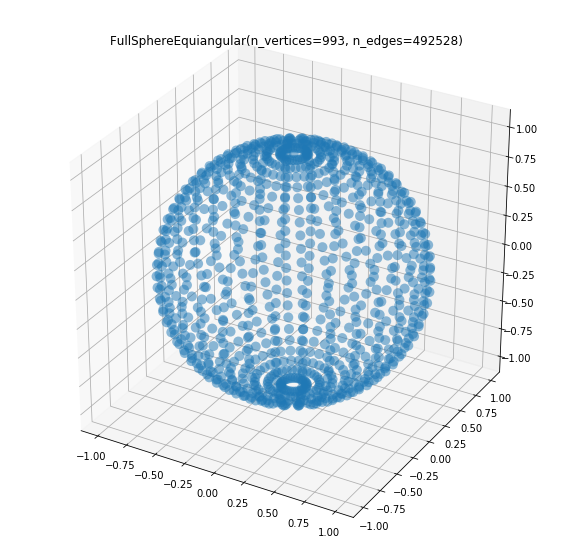

In [2]:
plt.rcParams['figure.figsize'] = (10, 10)
FullSphereEquiangular(16).plot()
plt.savefig('equiangular.png')

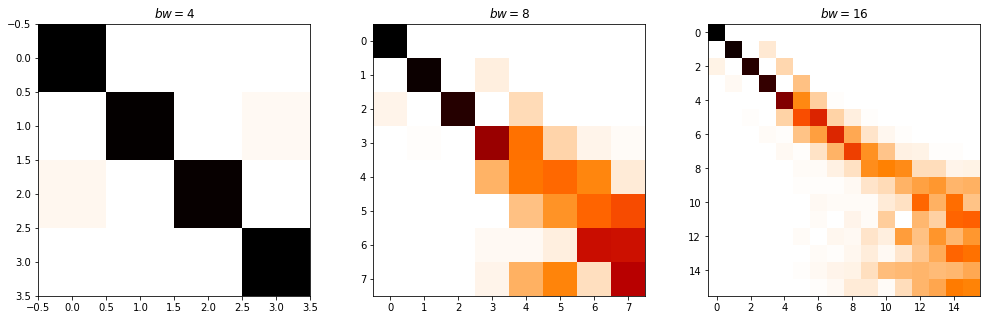

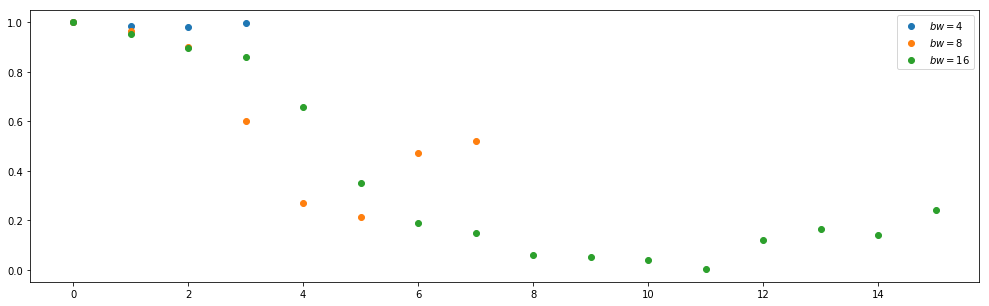

In [18]:
plt.rcParams['figure.figsize'] = (17, 5)

bws = [4, 8, 16]
graphs = []
spectral_content = dict()

for bw in bws:

    lmax = bw-1

    n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))[-1]
    graphs.append(FullSphereEquiangular(bw))
    graph = graphs[-1]

    graph.compute_fourier_basis(n_eigenvectors=n_harmonics)

    cl = np.empty((n_harmonics, lmax+1))
    for i in range(n_harmonics):
        eigenvector = graph.U[:, i]
        eig_array = to_array(eigenvector, bw)
        g = pyshtools.SHGrid.from_array(eig_array)
        clm = g.expand(normalization='unnorm')
        cl[i] = clm.spectrum()

    spectral_content[bw] = np.empty((lmax+1, lmax+1))
    start = 0
    for ell in range(lmax+1):
        end = start + (2 * ell + 1)
        spectral_content[bw][ell] = np.sum(cl[start:end,:], axis=0)/np.sum(cl[start:end,:])
        start = end

fig1, axes = plt.subplots(1, len(bws))
fig2, ax2 = plt.subplots()

for ax, (bw, sc) in zip(axes, spectral_content.items()):
    sc = sc / sc[0, 0]
    im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
    ax.set_title(rf'$bw={bw}$')
    energy_in = np.diag(sc)
    ax2.plot(energy_in, 'o', label=rf'$bw={bw}$')

ax2.legend();

fig1.savefig("equi_full.png")
fig2.savefig("equi_full_diagonal.png")

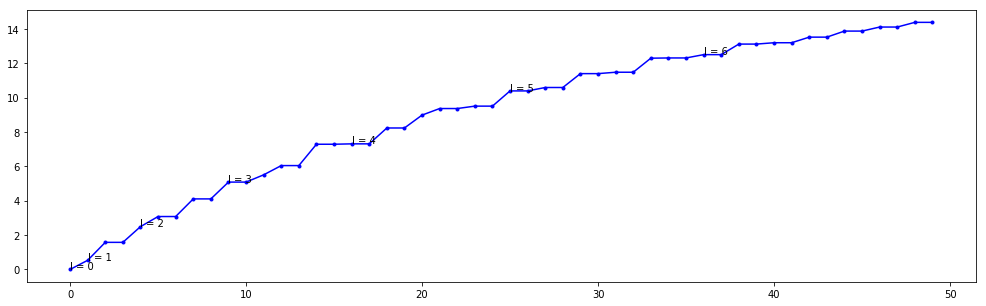

In [19]:
graph = graphs[-1]
plt.plot(graph.e[:50], 'b.')
plt.plot(graph.e[:50], 'b-')
for idx in range(7):
    plt.text(idx**2, graph.e[idx**2] + 0.006, 'l = {}'.format(idx));
plt.savefig('equi_full_eigenvalues_16')

# Try Khasanova and Frossard


In [2]:
import healpy as hp


In [12]:
class SphereEquiangularFrossard(Graph):
    def __init__(self, bw=64, sptype='DH', pole='all', neighbors=4, weights=None, dist=None, 
                 affine=0., **kwargs):
        """Sphere with an equiangular sampling
         Parameters
        ----------
        bw : int
            bandwidth, size of grid  (default = 64)
        sptype: str
            sampling type, possible arguments are 'DH', 'SOFT', ... (default = 'DH')
        pole: str
            how to manage the pole of the sphere, possible arguments are 'all', 'one', 'zero' (default = 'all')
        ---------
        TODO: unique on neighbor
        TODO: CC and GL are not equiangular and must be implement in other ways
        """
        self.bw = bw
        self.sptype = sptype
        self.pole = pole
        if pole not in ['all', 'one', 'zero']:
            raise ValueError('Unknown pole value:' + pole) 
        if sptype not in ['DH', 'SOFT']:
            raise ValueError('Unknown sampling type:' + sptype) 
        if sptype is not 'DH' and pole is not 'zero':
            print('pole can be only zero with sampling type ' + sptype)
            pole = 'zero'
        
        ## sampling and coordinates calculation
        if sptype is 'DH':
            beta = np.arange(2 * bw) * np.pi / (2. * bw)  # Driscoll-Heally
            alpha = np.arange(2 * bw) * np.pi / bw
            if pole is 'zero':
                beta = np.arange(2 * bw + 1) * np.pi / (2. * bw + 1)
        elif sptype is 'SOFT':  # SO(3) Fourier Transform optimal
            beta = np.pi * (2 * np.arange(2 * bw) + 1) / (4. * bw)
            alpha = np.arange(2 * bw) * np.pi / bw
        elif sptype == 'CC':  # Clenshaw-Curtis
            beta = np.linspace(0, np.pi, 2 * bw + 1)
            alpha = np.linspace(0, 2 * np.pi, 2 * bw + 2, endpoint=False)
        elif sptype == 'GL':  # Gauss-legendre
            from numpy.polynomial.legendre import leggauss
            x, _ = leggauss(bw + 1)  # TODO: leggauss docs state that this may not be only stable for orders > 100
            beta = np.arccos(x)
            alpha = np.arange(2 * bw + 2) * np.pi / (bw + 1)
        if pole is not 'all' and sptype is 'DH':
            beta = beta[1:]
        theta, phi = np.meshgrid(*(beta, alpha),indexing='ij')
        ct = np.cos(theta).flatten()
        st = np.sin(theta).flatten()
        cp = np.cos(phi).flatten()
        sp = np.sin(phi).flatten()
        x = st * cp
        y = st * sp
        z = ct
        coords = np.vstack([x, y, z]).T
        if pole is 'one':
            coords = np.vstack([[0., 0., 1.],coords])
        coords = np.asarray(coords, dtype=np.float32)
        
        ## neighbors and weight matrix calculation
        def south(x, bw):
            if x >= (2*bw)*(2*bw-1):
                return north((x+bw)%(2*bw)+(2*bw)*(2*bw),bw)
            elif self.pole is 'zero' and x >= (2*bw)*(2*bw-1):
                return north((x+bw)%(2*bw)+(2*bw)*(2*bw-1),bw)
            else:
                return x + 2*bw

        def north(x, bw):
            if x < 2*bw:
                return (x+bw)%(2*bw)
            else:
                return x - 2*bw

        def west(x, bw):
            if x%(2*bw)==0:
                x += 2*bw
            return x -1

        def east(x, bw):
            if x%(2*bw)==2*bw-1:
                x -= 2*bw
            return x + 1

        npix = len(coords)
        col_index=[]
        for ind in range(len(coords)):
            # first line is the same point, so is connected to all points of second line
            if pole is 'all' and sptype and ind < 2* bw:
                if ind == 0:
                    neighbor = np.arange(2*bw)+2*bw # np.arange(1,4*bw)
                else:
                    neighbor = np.arange(2*bw)+2*bw # [0]
            elif pole is 'all' and ind < 4*bw:
                if neighbors==8:
                    neighbor = [south(west(ind,bw),bw), west(ind,bw), east(ind,bw), south(east(ind,bw),bw), south(ind,bw)]
                elif neighbors==4:
                    neighbor = [west(ind,bw), east(ind,bw), south(ind,bw)]
                else:
                    neighbor = []
                neighbor += list(range(2*bw)) # [0]
            elif pole is 'one' and ind == 0:
                neighbor = np.arange(1, 2*bw+1)
            elif pole is 'one' and ind < 2*bw+1:
                ind += 2*bw - 1
                if neighbors==8:
                    neighbor = [south(west(ind,bw),bw), west(ind,bw), east(ind,bw), south(east(ind,bw),bw), south(ind,bw)]
                elif neighbors==4:
                    neighbor = [west(ind,bw), east(ind,bw), south(ind,bw)]
                else:
                    neighbor = []
                neighbor += [0]
            else:
                if pole is 'one':
                    ind += 2*bw - 1
                if neighbors==8:
                    neighbor = [south(west(ind,bw),bw), west(ind,bw), north(west(ind,bw), bw), north(ind,bw), 
                                north(east(ind,bw),bw), east(ind,bw), south(east(ind,bw),bw), south(ind,bw)]
                elif neighbors==4:
                    neighbor = [west(ind,bw), north(ind,bw), east(ind,bw), south(ind,bw)]
                else:
                    neighbor = []
            neighbor = np.asarray(neighbor)
            if pole is 'one' and ind != 0:
                neighbor -= 2*bw - 1
                neighbor[neighbor<0] = 0
            #neighbors.append(neighbor)
            col_index += list(neighbor)
        # neighbors = np.asarray(neighbors)
        col_index = np.asarray(col_index)

        #col_index = neighbors.reshape((-1))
        if pole is 'all':
            row_index = np.hstack([np.repeat(np.arange(0,2*bw), 2*bw), np.repeat(np.arange(2*bw,4*bw), neighbors//2+1+2*bw),#2*bw+5), 
                                  np.repeat(np.arange(4*bw, npix), neighbors)])
        elif pole is 'one':
            row_index = np.hstack([np.repeat(0, 2*bw), np.repeat(np.arange(1, 2*bw+1), neighbors//2+2),
                                  np.repeat(np.arange(2*bw+1, npix), neighbors)])
        elif pole is 'zero':
            row_index = np.repeat(np.arange(npix), neighbors)

        distances = np.sum((coords[row_index] - coords[col_index])**2, axis=1)
        # slower: np.linalg.norm(coords[row_index] - coords[col_index], axis=1)**2
        if dist=='geodesic':
            distances = np.zeros(len(row_index))
            for i, (pos1, pos2) in enumerate(zip(coords[row_index], coords[col_index])):
                d1, d2 = hp.rotator.vec2dir(pos1.T, lonlat=False).T, hp.rotator.vec2dir(pos2.T, lonlat=False).T
                distances[i] = hp.rotator.angdist(d1, d2, lonlat=False)
        
        weights = 1/distances
        
        plt.hist(distances, 100)
        
        if weights == 'one':
            weights = distances/distances


        # Similarity proposed by Renata & Pascal, ICCV 2017.
        # weights = 1 / distances

        # Build the sparse matrix.
        W = sparse.csr_matrix(
            (weights, (row_index, col_index)), shape=(npix, npix), dtype=np.float32)
        
        plotting = {"limits": np.array([-1, 1, -1, 1, -1, 1])}
        super(SphereEquiangularFrossard, self).__init__(W=W, coords=coords,
                                     plotting=plotting, **kwargs)

/Users/Mart/anaconda3/envs/pdm/lib/python3.7/site-packages/ipykernel_launcher.py:154: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


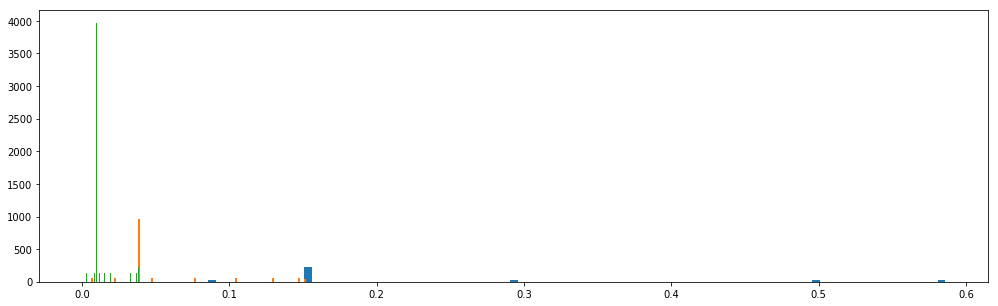

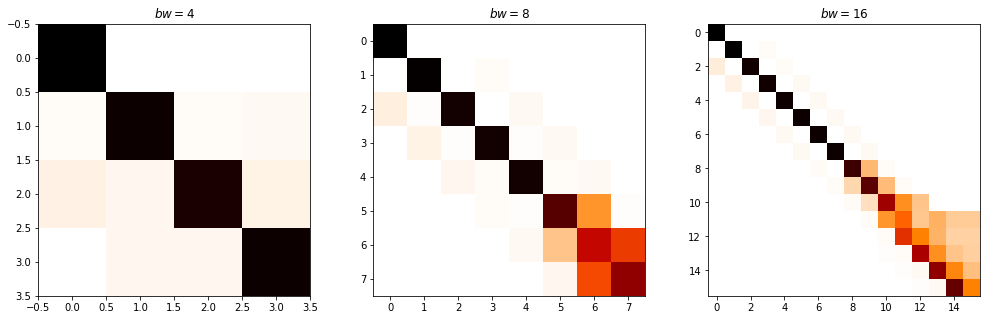

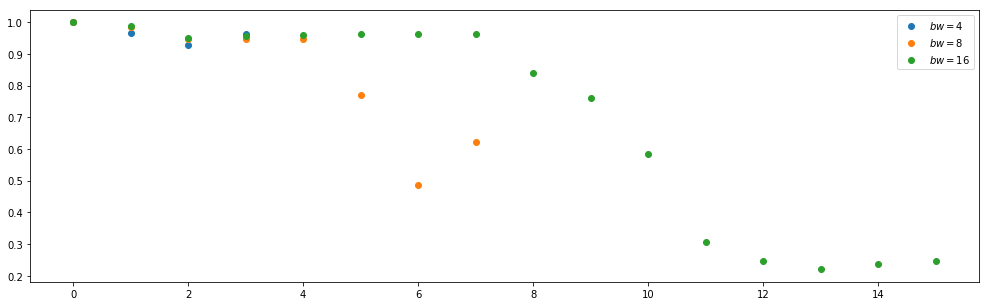

In [13]:
plt.rcParams['figure.figsize'] = (17, 5)

bws = [4, 8, 16]
graphs = []
spectral_content = dict()


def to_array(f, bw):
    
    """From a 1-d vector to a 2D grid necessary to initiate a pyshtools.SHGrid object"""
    height, width = 2*bw, 2*bw
    array = np.zeros((height, width))  # shape=(longitude, latitude)
    # f = np.append([f[0]]*(2*bw-1), f)  # correct! the first line is the North pole repeated 2bw times
    # now we need to undo the meshgrid
    assert f.size == array.size
    for n, fx in enumerate(f):
        j = n%width
        i = n//width
        array[i, j] = fx
    return array


for bw in bws:

    lmax = bw-1

    n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))[-1]
    graphs.append(SphereEquiangularFrossard(bw. dist='geodesic'))
    graph = graphs[-1]

    graph.compute_fourier_basis(n_eigenvectors=n_harmonics)

    cl = np.empty((n_harmonics, lmax+1))
    for i in range(n_harmonics):
        eigenvector = graph.U[:, i]
        eig_array = to_array(eigenvector, bw)
        g = pyshtools.SHGrid.from_array(eig_array)
        clm = g.expand(normalization='unnorm')
        cl[i] = clm.spectrum()

    spectral_content[bw] = np.empty((lmax+1, lmax+1))
    start = 0
    for ell in range(lmax+1):
        end = start + (2 * ell + 1)
        spectral_content[bw][ell] = np.sum(cl[start:end,:], axis=0)/np.sum(cl[start:end,:])
        start = end

fig1, axes = plt.subplots(1, len(bws))
fig2, ax2 = plt.subplots()

for ax, (bw, sc) in zip(axes, spectral_content.items()):
    sc = sc / sc[0, 0]
    im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
    ax.set_title(rf'$bw={bw}$')
    energy_in = np.diag(sc)
    ax2.plot(energy_in, 'o', label=rf'$bw={bw}$')

ax2.legend();

#fig1.savefig("equi_Khasanova_Frossard_full.png")
#fig2.savefig("equi_Khasanova_Frossard_full_diagonal.png")

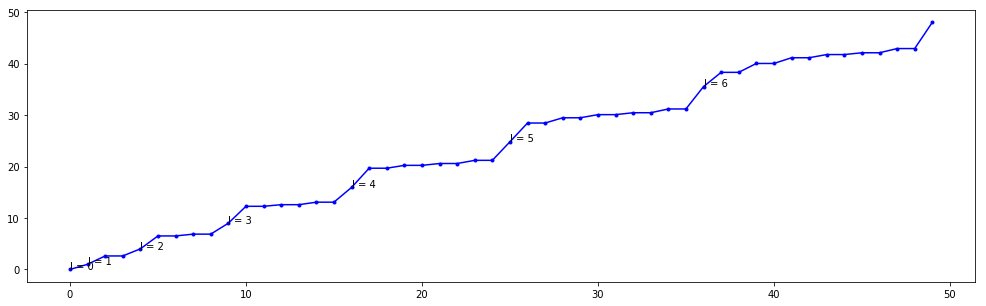

In [14]:
graph = graphs[-1]
plt.plot(graph.e[:50], 'b.')
plt.plot(graph.e[:50], 'b-')
for idx in range(7):
    plt.text(idx**2, graph.e[idx**2] + 0.006, 'l = {}'.format(idx));
plt.savefig('equi_full_Khasanova_Frossard_eigenvalues_16')

# Experience for Pierre

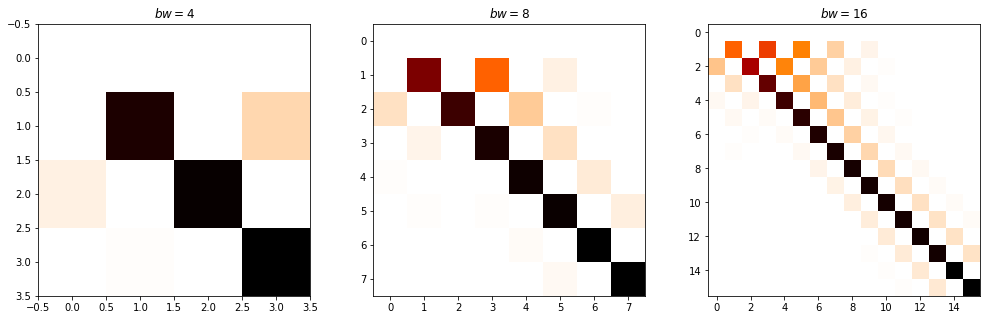

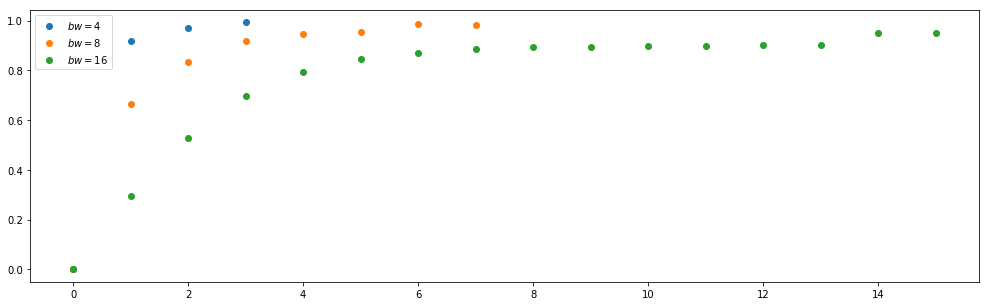

In [13]:
import scipy

plt.rcParams['figure.figsize'] = (17, 5)

bws = [4, 8, 16]
graphs = []
spectral_content = dict()

for bw in bws:

    lmax = bw-1
    graphs.append(FullSphereEquiangular(bw))
    graph = graphs[-1]
    
    cl = np.zeros((lmax+1, lmax+1))
    for ell in range(1, lmax+1):
        for m in range(-ell, ell+1):
            
            # finding the spherical harmonic Y(\ell=i, m=j)
            clm = pyshtools.SHCoeffs.from_zeros(lmax=lmax)
            clm.set_coeffs(values=1., ls=ell, ms=m)
            # transforming into the spatial domain
            g = clm.expand()
            sh = g.data.flatten()[2*bw-1:]
            
            # filtering
            sh_filtered = graph.L@sh
            
            # transforming back into the spectral domain
            sh_array = to_array(sh_filtered, bw)
            
            g = pyshtools.SHGrid.from_array(sh_array)
            clm = g.expand()
            
            
            # summing the contributions of all SHs of the same degree ell
            spectrum = clm.spectrum()
            spectrum = spectrum/np.max(spectrum)
            cl[ell] += spectrum
        
        # normalizing the row of cl
        cl[ell] = cl[ell]/np.sum(cl[ell])
    spectral_content[bw] = cl

fig1, axes = plt.subplots(1, len(bws))
fig2, ax2 = plt.subplots()

for ax, (bw, sc) in zip(axes, spectral_content.items()):
    im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
    ax.set_title(rf'$bw={bw}$')
    energy_in = np.diag(sc)
    ax2.plot(energy_in, 'o', label=rf'$bw={bw}$')

ax2.legend();

